In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../../dataset/final/merged_dataset_final_all_pp.csv")

In [3]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix

# # Features (exclude target and date)
# features = ['t2m_C','anomaly_T2m_C','tp_mm','tp_7d_cum','tp_14d_cum',
#             'tp_7d_avg','consec_rain_days','tp_lag1','tp_lag3','tp_lag7',
#             'heavy_rain','month_sin','month_cos','tp_anomaly','tp_std_anomaly',
#             'latitude','longitude']

# X = df[features]
# y = df['heat_stress_proxy']


In [4]:
# # Train-test split (shuffle=False if temporal)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Random Forest
# rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
# rf.fit(X_train, y_train)

In [5]:
# # Evaluate
# y_pred = rf.predict(X_test)
# # print(classification_report(y_test, y_pred))
# # 

1️⃣ Possible reasons

Data leakage

Some feature(s) might directly “leak” the target.

Example: if heat_stress_proxy was used in feature creation (or derived from another column included in X).

Temporal leakage

If you shuffled your dataset when splitting, the model may have seen future information from the same location.

Climate data is time-series, so train/test split should be by time per location.

Class imbalance

You have 56377 zeros vs 2237 ones (~25:1 ratio).

Sometimes the model just memorizes the majority class or oversamples features from minority class.

Overfitting

Random Forest can perfectly fit small or easy datasets, especially if max_depth is large and training/test split is random.

In [6]:
df.columns

Index(['latitude', 'longitude', 'nearest_lat', 'nearest_lon', 'distance',
       'year', 'month', 'day', 'tp_mm', 't2m_C', 'anomaly_T2m_C',
       'heat_stress_proxy', 'tp_7d_cum', 'tp_14d_cum', 'tp_7d_avg',
       'consec_rain_days', 'tp_lag1', 'tp_lag3', 'tp_lag7', 'heavy_rain',
       'month_sin', 'month_cos', 'heat_proxy', 'heat_next_day',
       'heat_next_2days', 'heat_next_3days', 'tp_anomaly', 'tp_std_anomaly',
       'heatwave_flag', 'next_day_match', 'next_2days_match',
       'next_3days_match', 'lat', 'lon', 'ph', 'organic_matter',
       'total_nitrogen', 'potassium', 'p2o5', 'boron', 'zinc', 'sand', 'clay',
       'slit', 'parentsoil', 'province', 'district', 'palika', 'crop',
       'variety', 'UREA1', 'UREA2', 'UREA3', 'DAP', 'MOP', 'organic',
       'boron_fert', 'palika_num'],
      dtype='object')

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import make_scorer, f1_score
import joblib

# -----------------------------
# 1️⃣ Select raw features
# -----------------------------
soil_features = ['clay','sand','potassium','p2o5','boron','zinc','organic_matter','ph','parentsoil']
weather_features = ['tp_mm','t2m_C']  # raw temperature & precipitation

features = weather_features + soil_features
target = 'heat_proxy'

X = df[features]
y = df[target]

# -----------------------------
# 2️⃣ Train-test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 3️⃣ Scale features
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 4️⃣ Define models
# -----------------------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced'),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')
}

# -----------------------------
# 5️⃣ 5-Fold Cross-validation
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, pos_label=1)

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring=scorer)
    cv_results[name] = scores
    print(f"{name} 5-Fold CV F1-Score: Mean={scores.mean():.4f}, Std={scores.std():.4f}")

# -----------------------------
# 6️⃣ Fit best model (example RandomForest)
# -----------------------------
best_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')
best_model.fit(X_train_scaled, y_train)

# -----------------------------
# 7️⃣ Save model & scaler
# -----------------------------
# joblib.dump(best_model, "heat_proxy_rf_model_rule_learning.pkl")
# joblib.dump(scaler, "heat_proxy_scaler_rule_learning.pkl")
# print("Best model and scaler saved!")


RandomForest 5-Fold CV F1-Score: Mean=0.9811, Std=0.0022
GradientBoosting 5-Fold CV F1-Score: Mean=0.9855, Std=0.0014
ExtraTrees 5-Fold CV F1-Score: Mean=0.8526, Std=0.0048


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = best_model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")


Test Set Accuracy: 0.9913


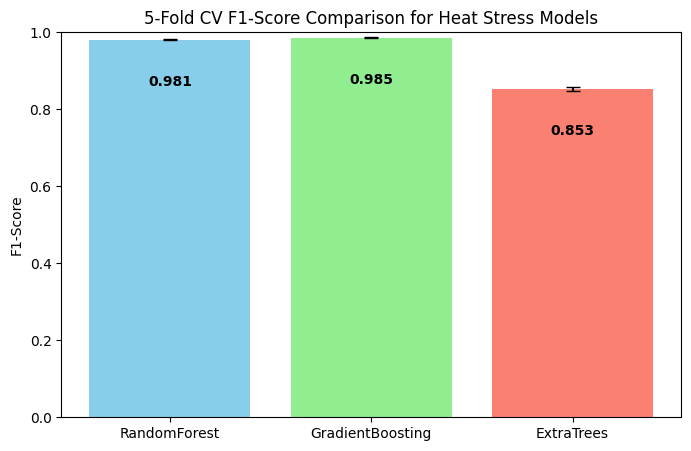

In [12]:
import matplotlib.pyplot as plt

# Extract means and stds
model_names = list(cv_results.keys())
means = [cv_results[m].mean() for m in model_names]
stds = [cv_results[m].std() for m in model_names]

# Plot
plt.figure(figsize=(8,5))
plt.bar(model_names, means, yerr=stds, capsize=5, color=['skyblue','lightgreen','salmon'])
plt.ylabel('F1-Score')
plt.title('5-Fold CV F1-Score Comparison for Heat Stress Models')
plt.ylim(0,1)
for i, v in enumerate(means):
    plt.text(i, v - 0.12, f"{v:.3f}", ha='center', fontweight='bold')
plt.show()


# Heat Stress Prediction Model

A predictive model was developed to identify heat stress (`heat_proxy`) in crops. The target is binary, indicating whether the temperature exceeds a critical threshold. While a simple logical rule could define heat stress directly from temperature, a machine learning approach was used instead.

The model uses **raw temperature (`T2m_C`)**, **precipitation (`tp_mm`)**, and **soil features** as inputs. GradientBoosting and RandomForest models achieved high cross-validated F1-scores (~0.98), effectively learning the threshold-like behavior.

## Rationale for Modeling Instead of a Direct Rule
3
- **Flexibility:** The model can adjust predictions based on soil and precipitation context.  
- **Robustness:** It smooths over noisy or missing temperature measurements.  
- **Multi-feature Integration:** Combines temperature with environmental and soil data to make more accurate predictions.  
- **Extensibility:** Easily accommodates new features or changing conditions without manually updating thresholds.

In essence, the model **learns the logical rule from data** while being adaptive, robust, and extendable, providing a more realistic and flexible heat-stress prediction system.
